In [38]:
import math
import pandas as pd
import torch
from torch import nn

In [39]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_hiddens, ffn_num_outputs) -> None:
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)
    
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [40]:
ffn = PositionWiseFFN(4, 8)
ffn(torch.ones(2,3,4)).shape,ffn(torch.ones(2,3,4))[0].shape

(torch.Size([2, 3, 8]), torch.Size([3, 8]))

In [41]:
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()

X = torch.tensor([[1,2],[2,3]],dtype=torch.float32)
print(f'layer norm: {ln(X)} \nbatch norm:{bn(X)}')

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm:tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [42]:
class AddNorm(nn.Module):
    
    def __init__(self, norm_shape, dropout) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)
        
    def forward(self, X, Y):
        return self.ln(self.dropout(Y)+X)
    

In [43]:
add_norm = AddNorm(4, 0.5)
shape = (2, 3, 4)
add_norm(torch.ones(shape), torch.ones(shape)).shape

torch.Size([2, 3, 4])

In [44]:
from d2l_common import MultiHeadAttention, PositionEncoding 

class TransformerEncoderBlock(nn.Module):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias=False):
        super().__init__()
        self.attention = MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
    
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        #(batch_size, n , num_hiddens)
        return self.addnorm2(Y, self.ffn(Y))

In [45]:
X = torch.ones(2,100,24)
valid_lens = torch.tensor([3,2])

encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()

assert encoder_blk(X, valid_lens).shape == X.shape

In [46]:
from d2l_common import Encoder
from collections import OrderedDict


class TransformerEncoder(Encoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential(
            OrderedDict(
                [(f'block-{i}', TransformerEncoderBlock(
                    num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias)) for i in range(num_blks)]
            )
        )

    def forward(self, X, valid_lens):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attn_weights
        return X

In [47]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
encoder(torch.ones(2, 100,dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [55]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i) -> None:
        super().__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)
        
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps+1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [56]:
decoder_blk = TransformerDecoderBlock(24, 48, 8, 0.5, 0)
X = torch.ones(2, 100, 24)

state = [encoder_blk(X, valid_lens), valid_lens, [None]]

decoder_blk(X, state)[0].shape

/Users/tangyun/opt/miniconda3/envs/rl/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 100, 24])

In [57]:
from d2l_common import AttentionDecoder


class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential(
            OrderedDict(
                [(f'block-{i}', TransformerDecoderBlock(num_hiddens,
                  ffn_num_hiddens, num_heads, dropout, i)) for i in range(num_blks)]
            )
        )
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
        self._attention_weights = [[None]*len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][i] = blk.attention1.attention.attn_weights
            self._attention_weights[1][i] = blk.attention2.attention.attn_weights
        return self.dense(X), state
    
    @property
    def attention_weights(self):
        return self._attention_weights

In [58]:
from d2l_common import MTFraEng, Trainer, Seq2Seq

data = MTFraEng(batch_size=128)

num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout)

model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],lr=0.001)
trainer = Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)


complete 0 epoch train_loss=1.3797824382781982 validate_loss=1.368479609489441
complete 1 epoch train_loss=0.36522477865219116 validate_loss=0.2251977175474167
complete 2 epoch train_loss=0.09114791452884674 validate_loss=0.05547548830509186
complete 3 epoch train_loss=0.03345978260040283 validate_loss=0.02296326495707035
complete 4 epoch train_loss=0.019325820729136467 validate_loss=0.01486694160848856
complete 5 epoch train_loss=0.019415024667978287 validate_loss=0.012298517860472202
complete 6 epoch train_loss=0.012692450545728207 validate_loss=1.9874660968780518
complete 7 epoch train_loss=0.016891952604055405 validate_loss=0.2088676393032074
complete 8 epoch train_loss=0.011205638758838177 validate_loss=0.018977459520101547
complete 9 epoch train_loss=0.01096110139042139 validate_loss=0.011598179116845131
complete 10 epoch train_loss=0.010795717127621174 validate_loss=0.010741611942648888
complete 11 epoch train_loss=0.010676061734557152 validate_loss=0.010466942563652992
complete

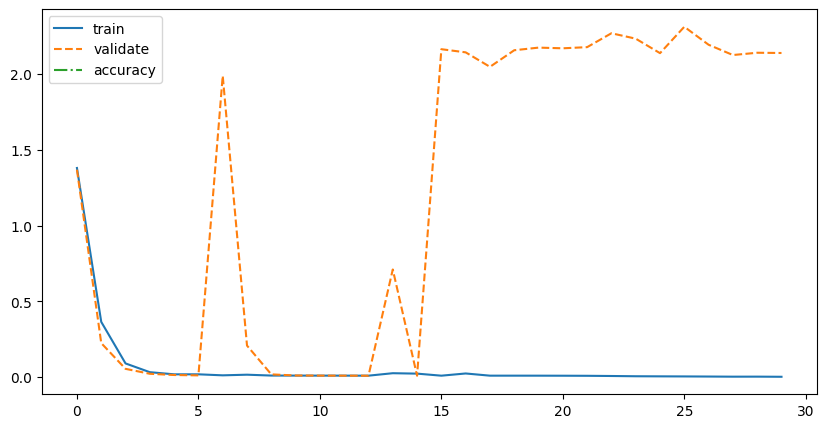

In [59]:
trainer.plot()

In [60]:
from d2l_common import bleu

engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), 'cpu', data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['détendue', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], bleu,0.000
i lost . => ['nous', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], bleu,0.000
he's calm . => ['nous', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], bleu,0.000
i'm home . => ['détendue', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], bleu,0.000


In [61]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), 'cpu', data.num_steps, True)
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0)
shape = (num_blks, num_heads, -1, data.num_steps)
enc_attention_weights = enc_attention_weights.reshape(shape)
enc_attention_weights.shape

NameError: name 'd2l' is not defined